<a href="https://colab.research.google.com/github/philnumpy/PRML-PROJECT/blob/main/KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>KMEANS

**K means** is an ***unsupervised machine learning*** technique that helps us group *unlabeled* data into various clusters on the basis of their similarity.

It is a ***“hard”*** clustering method. This form of grouping stipulates that a data point can exist in just one cluster.

It is an ***iterative, centroid-based*** clustering algorithm that partitions a dataset into similar groups based on the distance between their centroids. The centroid, or cluster center, is either the mean or median of all the points within the cluster depending on the characteristics of the data.



---



**<h3>Importing all important libraries**

In [1]:
import numpy as np
import pandas as pd #panel data that helps manipulate data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #to train test and split just in case
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.preprocessing import StandardScaler #to scale and normalise data

**Importing Data**

In [2]:
df=pd.read_csv("spotify_tracks.csv")
song_names=df["track_name"]

Preprocessing


In [3]:
df.drop_duplicates()
df.dropna()
languages = ["Hindi", "English"]  # List of languages to filter
df = df[df['language'].isin(languages)]



In [4]:
data=df.iloc[:,4:20]
data=pd.DataFrame(data)

In [5]:
data.drop("artwork_url",axis=1,inplace=True)

In [6]:
data.drop("album_name",axis=1,inplace=True)

In [7]:
print(data)



       popularity  acousticness  danceability  duration_ms  energy  \
7              18       0.11900         0.801      87089.0  0.5040   
11             34       0.28000         0.684     185802.0  0.7720   
15             12       0.45100         0.609      98400.0  0.4910   
141            45       0.02660         0.669     230741.0  0.8630   
149            27       0.00069         0.641     114194.0  0.7820   
...           ...           ...           ...          ...     ...   
61670           0       0.49200         0.713     181429.0  0.1720   
61671           0       0.63200         0.637     183659.0  0.1560   
61672           0       0.61800         0.720     182915.0  0.0991   
61673           0       0.64000         0.513     187580.0  0.5210   
61674           0       0.71100         0.635     181278.0  0.1760   

       instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
7                0.0000  4.0    0.1320    -5.771   0.0       0.2590  119.971   

**Scaling and Normalising data**

In [9]:
scaler=StandardScaler()
data= scaler.fit_transform(data) #to centre and scale the data preparing it for PCA s.t. mean is zero and standard deviation is 1

**<H3>PCA**

In SKLEARN,
Variation is calculated as:

(measurement-mean)^2/no. of samples

Below is the part where we do all the meansurements

In [8]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=4, kernel='rbf', gamma=0.1)  # Adjust gamma for non-linearity
data_kpca = kpca.fit_transform(data)

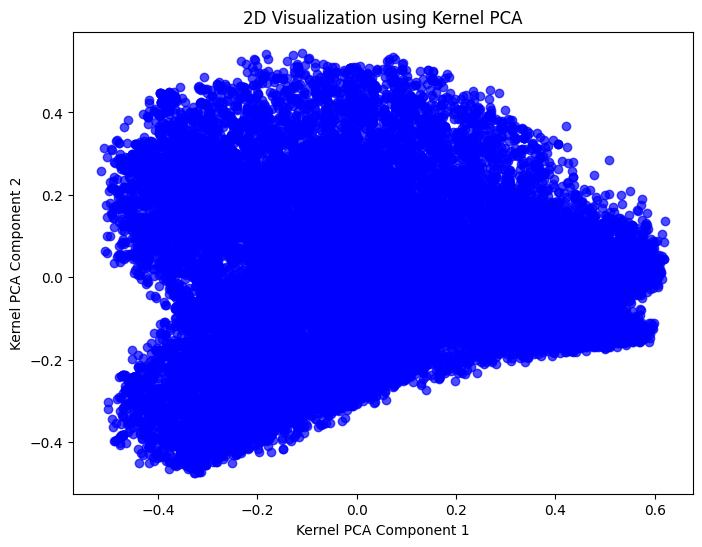

In [68]:
df_kpca = pd.DataFrame(data_kpca, columns=['KPCA1', 'KPCA2', 'KPCA3'])

# Plot first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(df_kpca['KPCA1'], df_kpca['KPCA2'], c='blue', alpha=0.7)
plt.xlabel('Kernel PCA Component 1')
plt.ylabel('Kernel PCA Component 2')
plt.title('2D Visualization using Kernel PCA')
plt.show()

In [88]:
pca = PCA(n_components=3)  #reducing the number of components to 2 since it is easier to observe in terms of clusters
data_pca = pca.fit_transform(data) #where we do all the pca math of loading scores and variations each pca accounts for(basically co-ordinates)
#we generate scores for a pca graph and variations

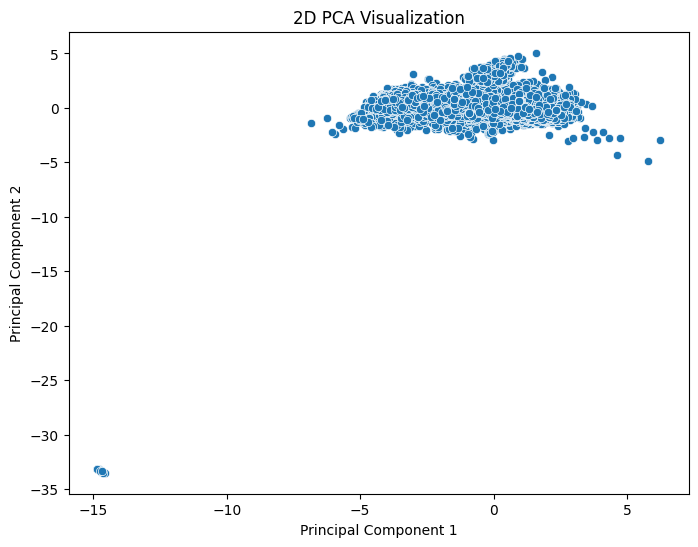

In [57]:
import seaborn as sns
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2','PC3'])

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Visualization')
plt.show()

**<h3>Optimising K means</h3>**

1. **Properly selecting the initial centroids**

 K Means++ is a more advanced method to initialise centroids as starting them out as random is a always a bad choice.


In [69]:
#K-Means++ for initial centroids
def kmeans_plus_plus(X, k): #gets data and k's value
    """Initialize centroids using K-Means++ method."""
    np.random.seed(42)  # For reproducibility
    n_samples = X.shape[0]

    #Randomly selecting the first centroid
    centroids = [X[np.random.randint(n_samples)]]

    for i in range(1, k):
        #Computing squared distances to the nearest centroid
        distances = np.array([min(np.linalg.norm(x - c) ** 2 for c in centroids) for x in X])

        #Choosing next centroid on the basis of probability proportional to distance²
        probabilities = distances / distances.sum()
        new_centroid_index = np.random.choice(n_samples, p=probabilities)

        # Adding the new centroid
        centroids.append(X[new_centroid_index])

    return np.array(centroids)

In [73]:
# Initialize centroids using K-Means++
initial_centroids = kmeans_plus_plus(data_kpca,2 )
print("Initial Centroids:\n", initial_centroids)

Initial Centroids:
 [[-0.07152706 -0.15262546 -0.27001764]
 [ 0.32838069  0.15160305  0.00149103]]


In [70]:
class KMeansFromScratch:
    def __init__(self, k=None, max_k=10, max_iters=100, tol=1e-4, auto_k=True):
        """
        k: Number of clusters (if None, auto-detect using Elbow method)
        max_k: Max clusters for Elbow method (used if auto_k=True)
        max_iters: Maximum iterations for convergence
        tol: Tolerance to stop iterations early
        auto_k: If True, automatically find the best k using Elbow method
        """
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.auto_k = auto_k
        self.max_k = max_k

    def fit(self, X):

        if self.auto_k and self.k is None:
            self.k = self.find_optimal_k(X)  # Find best k before clustering
        # Using K-Means++ for better initialisation
        self.centroids = kmeans_plus_plus(X, self.k)

        for i in range(self.max_iters):
            #Assigning points to nearest centroid, this is where clusters are forming
            #np.argmin returns the index of the closest centroid
            self.labels = np.array([np.argmin([np.linalg.norm(x - c) for c in self.centroids]) for x in X]) #euclidean distance is being considered

            #Computing new centroids
            '''
            For each cluster j, calculating the mean of all points assigned to it.

            This updates the centroid locations based on the new cluster assignments.
            for eg.
            cluster 1: (1,2) and (2,4) new mean will be (1.5,3) New Centroid-1
            cluster 2: (0,2) and (1,1.5) new mean will be (0.5,1.75) New Centroid-2
            '''
            new_centroids = np.array([X[self.labels == j].mean(axis=0) for j in range(self.k)])

            #Checking for convergence
            '''
            If centroids don’t change much (tol = small threshold),we stop iterating.

            This ensures that the algorithm stops when clusters are stable.
            '''
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break

            self.centroids = new_centroids  # Update centroids and the loop continues

    def predict(self, X):
        return np.array([np.argmin([np.linalg.norm(x - c) for c in self.centroids]) for x in X])
    def find_optimal_k(self, X):

        wcss = []
        for k in range(1, self.max_k + 1):
            kmeans = KMeansFromScratch(k=k, auto_k=False)  # Run K-Means manually
            kmeans.fit(X)
            wcss.append(sum(np.linalg.norm(X[kmeans.labels == j] - kmeans.centroids[j]) ** 2 for j in range(k)))

        return self.knee_locator(range(1, self.max_k + 1), wcss)

    @staticmethod
    def knee_locator(x, y):
        """ Find the 'knee' point (elbow) in the WCSS graph """
        x, y = np.array(x), np.array(y)
        # Compute second derivative (curvature)
        diff = np.gradient(y, edge_order=2)
        elbow_index = np.argmin(diff) + 1  # Adding 1 to match k index
        return x[elbow_index]

    def plot_elbow(self, X):
        """ Plot WCSS vs. k to visualize the Elbow Method """
        wcss = []
        for k in range(1, self.max_k + 1):
            kmeans = KMeansFromScratch(k=k, auto_k=False)
            kmeans.fit(X)
            wcss.append(sum(np.linalg.norm(X[kmeans.labels == j] - kmeans.centroids[j]) ** 2 for j in range(k)))

        best_k = self.knee_locator(range(1, self.max_k + 1), wcss)

        plt.figure(figsize=(8, 5))
        plt.plot(range(1, self.max_k + 1), wcss, marker='o', linestyle='--', color='b')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
        plt.title('Elbow Method for Optimal K')
        plt.axvline(x=best_k, linestyle='--', color='r', label=f'Optimal K = {best_k}')
        plt.legend()
        plt.show()
        print(f"Optimal K found: {best_k}")


2. **Optimum number of clusters improves the accuracy**

 It measures the euclidean distance between each data point and its cluster center and chooses the number of clusters based on where change in “within cluster sum of squares” (WCSS) levels off. This value represents the total variance within each cluster that gets plotted against the number of clusters. ***Best K is where the curve forms an elbow (sudden drop, then flattening).***

In [71]:
    def find_optimal_k(self, X):
        """ Automatically find the best k using the Elbow Method & Knee Point """
        wcss = []
        for k in range(1, self.max_k + 1):
            kmeans = KMeansFromScratch(k=k, auto_k=False)  # Run K-Means manually
            kmeans.fit(X)
            wcss.append(sum(np.linalg.norm(X[kmeans.labels == j] - kmeans.centroids[j]) ** 2 for j in range(k)))

        return self.knee_locator(range(1, self.max_k + 1), wcss)

    @staticmethod
    def knee_locator(x, y):
        """ Find the 'knee' point (elbow) in the WCSS graph """
        x, y = np.array(x), np.array(y)
        # Compute second derivative (curvature)
        diff = np.gradient(y, edge_order=2)
        elbow_index = np.argmin(diff) + 1  # Adding 1 to match k index
        return x[elbow_index]

    def plot_elbow(self, X):
        """ Plot WCSS vs. k to visualize the Elbow Method """
        wcss = []
        for k in range(1, self.max_k + 1):
            kmeans = KMeansFromScratch(k=k, auto_k=False)
            kmeans.fit(X)
            wcss.append(sum(np.linalg.norm(X[kmeans.labels == j] - kmeans.centroids[j]) ** 2 for j in range(k)))

        best_k = self.knee_locator(range(1, self.max_k + 1), wcss)

        plt.figure(figsize=(8, 5))
        plt.plot(range(1, self.max_k + 1), wcss, marker='o', linestyle='--', color='b')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
        plt.title('Elbow Method for Optimal K')
        plt.axvline(x=best_k, linestyle='--', color='r', label=f'Optimal K = {best_k}')
        plt.legend()
        plt.show()
        print(f"Optimal K found: {best_k}")



---



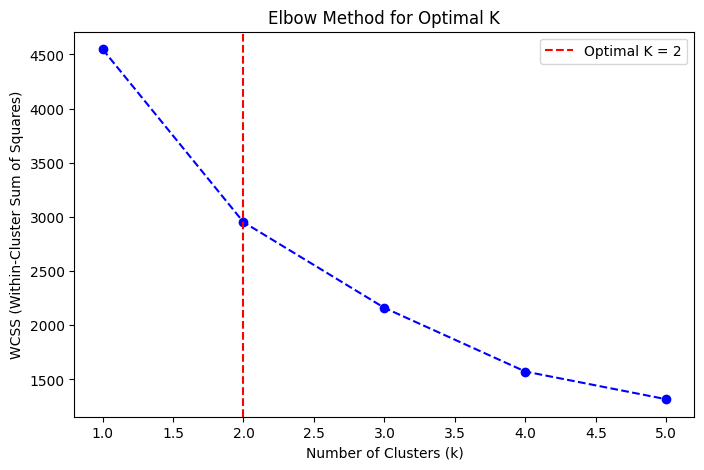

Optimal K found: 2


In [72]:
object=KMeansFromScratch(auto_k=True,max_k=5)
object.fit(data_kpca)
object.plot_elbow(data_kpca)

 **<h1> Cluster Evaluation Metrics </h1>**

1. All data points within a cluster should be similar.

2. Clusters should be distinct from each other.

The goal of the k-means clustering algorithm is to minimize the sum of squared errors (SSE)

**<h3>Inertia</h3>**

Inertia is calculated by measuring the distance between a datapoint and its centroid, squaring the distance and summing those squares for each data point in the cluster. The sum or inertial value is the intracluster distance. The lower the sum the better because it means that the datapoints within the cluster are compact or more similar.

**<h3>The Dunn index</h3>**

The second property is measured with the Dunn index. The Dunn index represents the relationship between the minimum intercluster distance and the maximum intracluster distance. Clusters with a high intercluster distance indicate better quality because it means that the clusters are as different from each other as possible.



---



<h3>Sources:


1.   https://www.ibm.com/think/topics/k-means-clustering
2.   List item
3.



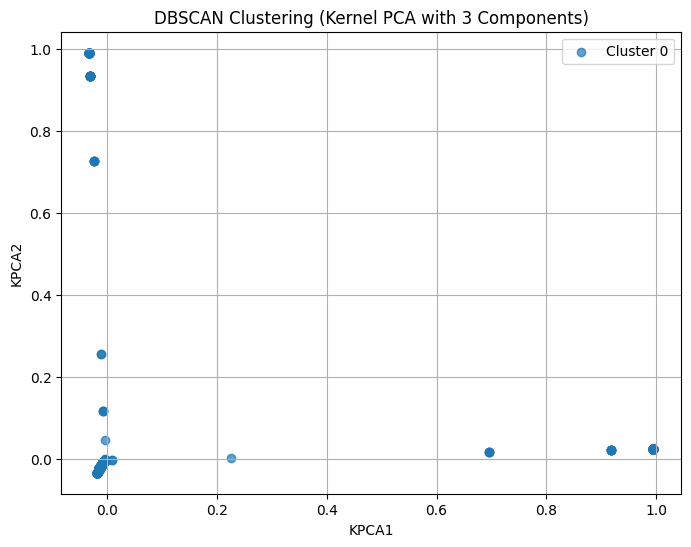

Number of clusters found by DBSCAN: 1
Number of noise points: 0


In [10]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=3, min_samples=10)  # You can tweak eps and min_samples
labels = dbscan.fit_predict(data_kpca)

# Step 5: Add cluster labels to DataFrame
df_kpca = pd.DataFrame(data_kpca, columns=[f"KPCA{i+1}" for i in range(4)])
df_kpca["Cluster"] = labels

# Step 6: Visualize using first two components
plt.figure(figsize=(8, 6))
unique_labels = np.unique(labels)
for label in unique_labels:
    color = 'black' if label == -1 else None  # black for noise
    cluster_points = df_kpca[df_kpca["Cluster"] == label]
    plt.scatter(cluster_points["KPCA1"], cluster_points["KPCA2"], label=f"Cluster {label}", alpha=0.7, color=color)

plt.xlabel("KPCA1")
plt.ylabel("KPCA2")
plt.title("DBSCAN Clustering (Kernel PCA with 3 Components)")
plt.legend()
plt.grid(True)
plt.show()

# Step 7: Report number of clusters and noise points
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Number of clusters found by DBSCAN: {n_clusters}")
print(f"Number of noise points: {n_noise}")

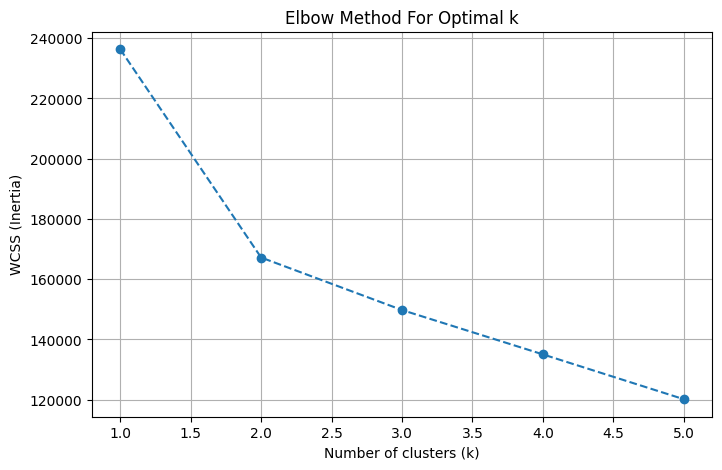

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score





# Step 4: Use Elbow Method to find the best value of k
wcss = []
k_range = range(1, 6)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS (within-cluster sum of squares)

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


In [86]:
pip install kneed


In [87]:
from kneed import KneeLocator

knee = KneeLocator(k_range, wcss, curve="convex", direction="decreasing")
optimal_k = knee.knee
print(f"Optimal k: {optimal_k}")

Optimal k: 2
